# What should I watch next?

Implementation of a movie recommendation system trained on the dataset [MovieLens25m](https://grouplens.org/datasets/movielens/25m/), which contains 25 million ratings applied to 62,000 movies by 162,000 users. The dataset also includes tag genome data with 15 million relevance scores across 1,129 tags, which we will not use in this project.

## Packages

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis and Preprocessing

In this section we want to get a feeling of the data and check if any data cleaning or preprocessing is required.
First, we load the data:

In [20]:
df_movies = pd.read_csv('data_25m/movies.csv')
df_ratings = pd.read_csv('data_25m/ratings.csv')

In [21]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Let us check if any missing value is present. 

In [23]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

No missing values found. We also check for the movie dataset, albeit not essential:

In [24]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Again, no missing values. 

Let us check that no duplicate ratings have been added by mistake:

In [38]:
df_movies.duplicated().sum()

0

We can proceed with the analysis.

We recall that ratings are essentially an (ordinal) categorical variable with the following distribution:

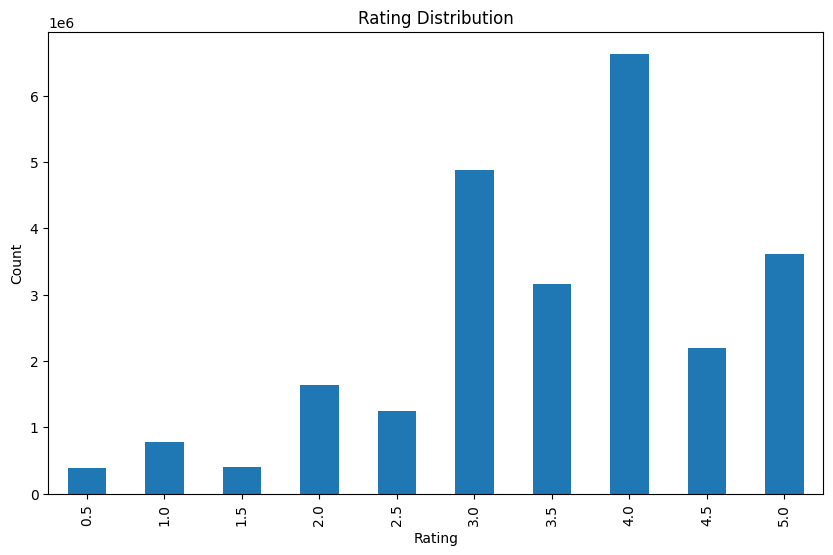

In [40]:
plt.figure(figsize=(10, 6))
df_ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

For the sake of the implementation of ALS no particular data cleaning procedure is needed: we will not need to handle genres (which would be necessary instead if we implemented a content based recommender) and we will not need metadata on movies and ratings. 

We will however need some of this information for building the "small" example we will use for visualizing the algorithm, as we will clarify later. Hence, we clean the genre column in the movie dataset:

In [25]:
df_movies['genres'] = df_movies['genres'].str.split('|')
df_movies_ohe = df_movies.join(df_movies.pop('genres').str.join('|').str.get_dummies())
df_movies_ohe.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The dataset is massive:

In [26]:
n_movies = df_movies_ohe.shape[0]
n_users = df_ratings['userId'].nunique()
print(f'Number of movies: {n_movies}')
print(f'Number of users: {n_users}')

Number of movies: 62423
Number of users: 162541


Of course, it wouldn't make sense to get rid of certain users before applying our algorithms: we want to be able to make recommendations for all our users, and all of them have a non-negligible minimum amount of ratings anyway:

In [27]:
user_freq = df_ratings['userId'].value_counts()
user_freq = user_freq.sort_values(ascending=False)
user_freq.describe()

count    162541.000000
mean        153.807932
std         268.047590
min          20.000000
25%          36.000000
50%          71.000000
75%         162.000000
max       32202.000000
Name: count, dtype: float64

On the contrary, we may look into the distribution of the ratings by movie:

In [28]:
movie_freq = df_ratings['movieId'].value_counts()
movie_freq = movie_freq.sort_values(ascending=False)
movie_freq.describe()

count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
Name: count, dtype: float64

Notice that 50% of movies have as low as 6 reviews. 
It is true that we aim at making recommendations that do not suffer from a popularity bias (i.e. mostly recommending popular movies to everyone), but to make things more manageable and provide meaninggul recommendations we drop all movies with less than 6 reviews. After all, with thousands of possible recommendations we wouldn't want to rely on movies with only a handful of them. Also, popularity bias is a common problem of neighbourhood methods, but by design matrix factorization algorithms do not tend to suffer from it.

This choice clearly affects the likelihood of recommending movies that have been only recently added to our library, but we believe this instance should rather be handled separately with a recommender for a "what's new?" or a "trending now" section of our recommendation website or streaming service. For movies that have been for a long time on the platform but only have a handful reviews, we can safely assume that they are "niche" items, which are likely to be specifally searched for by the few interested users.

In [29]:
df_ratings.shape[0]

(25000095, 4)

In [33]:
# drop all ratings of movies with less than 6 ratings
min_movie_ratings = 6
filter_movies = movie_freq[movie_freq >= min_movie_ratings].index
df_ratings = df_ratings[df_ratings['movieId'].isin(filter_movies)]
df_ratings.shape[0]

(24921929, 4)

It's hardly noticeable in terms of total number of ratings of course, but it significanly lowers the movies dimension (making the user-item matrix belong to a much smaller space). To explicitly refer to the notation of the report of the project:
$$
R\in\mathbb{R}^{n\times m} \longrightarrow R\in\mathbb{R}^{n\times m'} \text{ where } m'\approx\frac{m}{2}
$$

For the user-item matrix, we can also get rid of the timestamp column (which indicates the time at which a rating was given).

In [37]:
#

0

Let us now create the user-item matrix, for which 

Let us focus first on the movies dataset.

In [51]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


We look for missing values:

In [52]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

We should perform some data cleaning: 

In [53]:
df_movies["genres"] = df_movies["genres"].apply(lambda x: x.split("|"))
df_movies["year"] = df_movies["title"].str.extract(r"\((\d{4})\)", expand=False)
df_movies["title"] = df_movies["title"].str.replace(r"\s\(\d{4}\)", "", regex=True)
df_movies["year"].fillna(0, inplace=True)
df_movies["year"] = df_movies["year"].astype(int)
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


We should check that there was consistency in the way titles were inserted: this code would set the "year" column value to 0 if no match was found for the regular expression.

In [54]:
df_movies["year"].describe()

count    62423.000000
mean      1978.960768
std        162.886941
min          0.000000
25%       1976.000000
50%       2002.000000
75%       2012.000000
max       2019.000000
Name: year, dtype: float64

In [55]:
df_movies[df_movies["year"]==0].count()

movieId    410
title      410
genres     410
year       410
dtype: int64

In [67]:
# let us check how many ratings are there for these movies
df_ratings[df_ratings["movieId"].isin(df_movies[df_movies["year"] == 0]["movieId"])]
# gorup this by movieId and count the number of ratings
df_ratings[df_ratings["movieId"].isin(df_movies[df_movies["year"] == 0]["movieId"])].groupby("movieId").count().iloc[:,0].sort_values(ascending=False).values

array([2441, 2123, 1716, 1296,  571,  456,  277,  226,  192,  191,  190,
        147,  109,  109,   74,   69,   52,   50,   42,   41,   41,   40,
         39,   38,   37,   30,   27,   24,   23,   22,   21,   21,   21,
         20,   19,   19,   19,   18,   16,   15,   15,   14,   14,   13,
         13,   12,   12,   11,   11,   10,   10,   10,   10,    9,    9,
          9,    9,    9,    9,    9,    9,    8,    8,    8,    8,    7,
          7,    7,    7,    7,    7,    7,    6,    6,    6,    6,    6,
          5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    4,
          4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
          4,    4,    4,    4,    4,    4,    3,    3,    3,    3,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,   

In [68]:
# general distribution of the number of ratings for each movie
df_ratings.groupby("movieId").count().iloc[:,0].sort_values(ascending=False).describe()

count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
Name: userId, dtype: float64

Should we get rid of movies with less than $m$ reviews?

In [71]:
# total number of movies
df_movies["movieId"].nunique()

62423

Top 75% is still 15k movies, should be enough.

# SVD++ implementation

In [2]:
from surprise import SVDpp
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-1m')

# Split the dataset into train and test
trainset, testset = train_test_split(data, test_size=.25)

# Use SVD++ algorithm
algo = SVDpp()

# Train the algorithm on the trainset
algo.fit(trainset)

# Predict ratings for the testset
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Dataset ml-1m could not be found. Do you want to download it? [Y/n] Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to C:\Users\feder/.surprise_data/ml-1m
RMSE: 0.8639


0.8639251732665832

In [3]:
from surprise import KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-1m')

# Split the dataset into train and test
trainset, testset = train_test_split(data, test_size=.25)

# Use k-NN algorithm
algo = KNNBasic()

# Train the algorithm on the trainset
algo.fit(trainset)

# Predict ratings for the testset
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9254


0.9254039704112041

# ALS implementation

In [ ]:
tmp = pd.read_csv("data_25m/ratings.csv")

# select only ratings of movies having more than the 75-percentile of the number of reviews


In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# Initialize SparkSession
spark = SparkSession.builder.appName('ALS').getOrCreate()
# Load your data
# Replace 'path_to_your_data' with the actual path to your data file
data = spark.read.csv('data/ratings.csv', inferSchema=True, header=True)

# Assuming your data has three columns: 'userId', 'movieId', 'rating'
data = data.select(['userId', 'movieId', 'rating'])

# Split the data into training and test sets
(training, test) = data.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.0818403827803156


In [8]:
from pyspark.sql.functions import avg
# load data as a pyspark dataset
# Calculate the average rating
average_rating = data.select(avg("rating")).first()[0]

# Create a DataFrame with the average rating for every user-item pair in the test set
average_predictions = test.withColumn('prediction', lit(average_rating))

# Evaluate the model by computing the RMSE on the test data
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(average_predictions)
print("Root-mean-square error = " + str(rmse))

AttributeError: 'DatasetAutoFolds' object has no attribute 'select'

SVD++ explicit

In [ ]:
import numpy as np

class SVDpp:
    def __init__(self, n_epochs=20, n_factors=10, lr=0.005, reg=0.02):
        self.n_epochs = n_epochs
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg

    def fit(self, R):
        self.n_users, self.n_items = R.shape
        self.global_mean = np.mean(R[np.where(R != 0)])
        self.P = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.Q = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        self.Y = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        self.b_u = np.zeros(self.n_users)
        self.b_i = np.zeros(self.n_items)

        self.R = R

        for _ in range(self.n_epochs):
            for i in range(self.n_users):
                rated_items = np.where(R[i, :] != 0)[0]
                sqrt_n_ui = np.sqrt(len(rated_items))
                for j in rated_items:
                    err = R[i, j] - self.predict(i, j)
                    self.b_u[i] += self.lr * (err - self.reg * self.b_u[i])
                    self.b_i[j] += self.lr * (err - self.reg * self.b_i[j])
                    self.P[i, :] += self.lr * (err * self.Q[j, :] - self.reg * self.P[i,:])
                    self.Q[j, :] += self.lr * (err * (self.P[i, :] + (sqrt_n_ui * self.Y[rated_items, :].sum(axis=0))) - self.reg * self.Q[j,:])
                    self.Y[j, :] += self.lr * (err * self.Q[j, :] / sqrt_n_ui - self.reg * self.Y[j,:])

    def predict(self, i, j):
        if self.R[i, j] > 0:
            rated_items = np.where(self.R[i, :] != 0)[0]
            sqrt_n_ui = np.sqrt(len(rated_items))
            return self.global_mean + self.b_u[i] + self.b_i[j] + np.dot(self.P[i, :] + sqrt_n_ui * self.Y[rated_items, :].sum(axis=0), self.Q[j, :])
        return self.global_mean + self.b_u[i] + self.b_i[j] + np.dot(self.P[i, :], self.Q[j, :])

# Assume R is your ratings matrix
R = np.array([[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]])
model = SVDpp()
model.fit(R)
print(model.predict(0, 2))  # Predict the rating of user 0 for item 2

In [9]:
# ALS explicit
import numpy as np

class ALS:
    def __init__(self, n_factors=10, n_iterations=20, reg=0.01):
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.reg = reg

    def fit(self, R):
        self.n_users, self.n_items = R.shape
        self.user_factors = np.random.random((self.n_users, self.n_factors))
        self.item_factors = np.random.random((self.n_items, self.n_factors))

        for _ in range(self.n_iterations):
            for u in range(self.n_users):
                self.user_factors[u] = self.solve(R[u, :], self.item_factors, self.reg, self.n_factors)
            for i in range(self.n_items):
                self.item_factors[i] = self.solve(R[:, i], self.user_factors, self.reg, self.n_factors)

    def solve(self, v, U, reg, n_factors):
        A = np.dot(U.T, U) + np.eye(n_factors) * reg
        b = np.dot(U.T, v)
        return np.linalg.solve(A, b)

    def predict(self):
        return self.user_factors.dot(self.item_factors.T)

# Assume R is your ratings matrix
R = np.array([[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]])
model = ALS()
model.fit(R)
print(np.round(model.predict(), decimals=2))  # Predict the entire matrix

[[ 5.    2.99 -0.    1.  ]
 [ 4.    0.   -0.    1.  ]
 [ 1.    1.    0.    5.  ]
 [ 1.    0.    0.    4.  ]
 [-0.01  1.    4.99  3.99]]
